<a href="https://colab.research.google.com/github/osienka/uczenie-maszynowe/blob/main/Kopia_notatnika_05M_Bayes_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPAM vs. naiwny klasyfikator Bayesa**
Autor: Anna Dawid

Rozwiązanie: ZOfia Hendrysiak

## Wprowadzenie
Nigeryjski książę wciąż zarabia na użytkownikach elektronicznych skrzynek pocztowych ponad 700 tys. dolarów rocznie ([źródło](https://www.cnbc.com/2019/04/18/nigerian-prince-scams-still-rake-in-over-700000-dollars-a-year.html))! Jak to możliwe?

Pierwsza przyczyna jest natury psychologicznej. Ofiary są poddawane "perfekcyjnej burzy pokuszeń", jak ujął to psycholog w wywiadzie, do którego linka dałam Wam powyżej. Spammerzy łączą granie na ludzkiej chciwości, ale także na pragnieniu bycia bohaterem. W końcu kto nie chciałby zarobić na byciu wspaniałomyślnym i szczodrym? W tej kwestii możemy pracować wyłącznie nad sobą.

Możemy za to pracować nad filtrami antyspamowymi. Użyjemy techniki, która nazywa się "worek ze słowami" (bag of words) w połączeniu z naiwnym klasyfikatorem Bayesa. Choć to prosty klasyfikator, z powodzeniem jest używany współcześnie (np. [SpamAssassin](https://cwiki.apache.org/confluence/display/spamassassin/BayesInSpamAssassin)).

Notebook oparty na tutorialach:
*   https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73
*   https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import danych treningowych
https://www.kaggle.com/uciml/sms-spam-collection-dataset

To dane przygotowane przez Almeida et al. na podstawie forum brytyjskiego, gdzie użytkownicy skarżą się na spamowe SMSy. Każdy wiersz składa się z kolumny opisującej czy wiadomość jest spamem, czy nie ('spam' czy 'ham'), a druga zawiera treść wiadomości.

Proszę pobrać repozytorium ```uczenie-maszynowe-2021-22``` z serwisu github i uaktualnić ścieżkę do danych.

In [ ]:
!git clone https://github.com/akalinow/uczenie-maszynowe-2021-22
folder = './dane/'

Cloning into 'uczenie-maszynowe-2021-22'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 121 (delta 55), reused 84 (delta 25), pack-reused 0
Receiving objects: 100% (121/121), 1.90 MiB | 22.93 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
folder = './dane/'
df = pd.read_csv("/content/uczenie-maszynowe-2021-22/dane/spam_dataset.csv", encoding='latin-1')
print(df)
print(df.columns)

        v1  ... Unnamed: 4
0      ham  ...        NaN
1      ham  ...        NaN
2     spam  ...        NaN
3      ham  ...        NaN
4      ham  ...        NaN
...    ...  ...        ...
5567  spam  ...        NaN
5568   ham  ...        NaN
5569   ham  ...        NaN
5570   ham  ...        NaN
5571   ham  ...        NaN

[5572 rows x 5 columns]
Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


Dane zawierają zbyteczne kolumny. Proszę:
* usunać kolumny zawierająca wartości "NaN"
* zmienić nazwy kolumn "v1" i "v2" na "label", "text"

**Wskazówka**: proszę użyć metod ```DataFrame.drop()``` oraz ```DataFrame.rename()```

In [ ]:
df = df.drop(columns = ["Unnamed: 2","Unnamed: 3", "Unnamed: 4"])
print(df.columns)
df = df.rename(columns = {'v1': 'label', 'v2': 'text'})
df = df.dropna()
df.head()
df['target'] = [1 if i =="spam" else 0 for i in df["label"]]

Index(['v1', 'v2'], dtype='object')


Proszę wypisać na ekran treść maila o indeksie **57**

**Wskazówka**: Indeksy obiektu DataFreame uzyskujemy przez pole ```DataFrame.index```

In [ ]:
index = 57
print(df["text"][57])

Sorry, I'll call later in meeting.


Treść wiadomości:

Proszę wypisać na ekran liczebność danych, czyli liczbę maili.

In [ ]:
print("Data contains {} emails.".format(len(df)))

Data contains 5572 emails.


## Analiza częstości występowania słów w obu klasach za pomocą biblioteki WordCloud

To biblioteka pozwalająca generować śliczne obrazki, na których wielkość słów odpowiada częstości jego występowania w danym zbiorze.

In [ ]:
!pip3 install wordcloud
import wordcloud

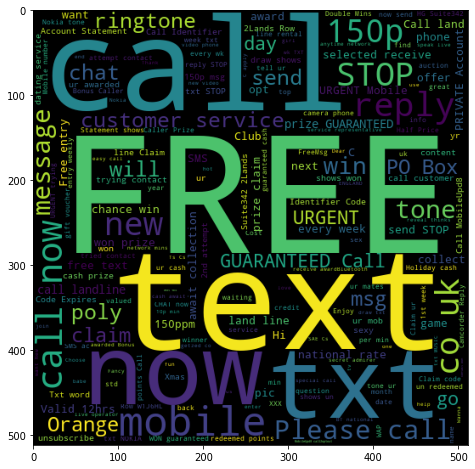

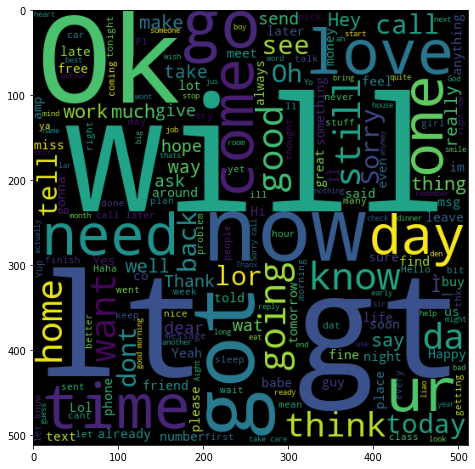

In [ ]:
from wordcloud import WordCloud

# najpierw słowa ze spamu
spam_words = " ".join(list(df [df['label']=='spam']['text'] ))
spam_plot = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize=(10,8))
plt.imshow(spam_plot);

# teraz słowa z normalnych wiadomosci
ham_words = " ".join(list(df [df['label']=='ham']['text'] ))
ham_plot = WordCloud(width = 512, height = 512).generate(ham_words)

plt.figure(figsize=(10,8))
plt.imshow(ham_plot);

Dane w tej chwili są w postaci ciągów słów. Zamienimy je na postać numeryczną używająć algorymtu ```CountVectorizer```.
Na początek zróbmy to dla prostego tekstu by zrozumieć jak działa ten algorytm. Proszę:
* zaimportować bibliotekę zawierającą algorytm:

```
from sklearn.feature_extraction.text import CountVectorizer
```
* używając metody ```CountVectorizer.fit(...)``` przeprowadzić trening algorytmu na zdaniach 

```
["Ala ma kota.", "Kot? Kot ma wszy.]
```
* wypisać na ekran słownik utworzony przez algorytm ```CountVectorizer```: ```CountVectorizer.vocabulary_```
* wypisać na ekran listę znalezionych słów: ```CountVectorizer.get_feature_names()```
* przepowadzić transformację zdania do postaci numerycznej: ```CountVectorizer.transform(...)```
* przeprowadzić transformację odwrotną:```vectorizer.inverse_transform(...)```
* wypisać na ekran wszystkie reprezentacje zdania

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
text = ["Ala ma kota.", "Kot? Kot ma wszy."]
vectorizer = CountVectorizer()
vectorizer.fit(text)
print("Vocabulary:",vectorizer.vocabulary_)
print("Lista słów:",vectorizer.get_feature_names())
text_transformed = vectorizer.transform(text)
print("Original text:",text)
print("Transformed text:",text_transformed)
print("Transformed text after decoding",vectorizer.inverse_transform(text_transformed))

Vocabulary: {'ala': 0, 'ma': 3, 'kota': 2, 'kot': 1, 'wszy': 4}
Lista słów: ['ala', 'kot', 'kota', 'ma', 'wszy']
Original text: ['Ala ma kota.', 'Kot? Kot ma wszy.']
Transformed text:   (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (1, 1)	2
  (1, 3)	1
  (1, 4)	1
Transformed text after decoding [array(['ala', 'kota', 'ma'], dtype='<U4'), array(['kot', 'ma', 'wszy'], dtype='<U4')]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Proszę:

* przeprowadzić procedurę treningu i transformacji dla danych z e-maili.
* proszę wypisać na ekran postać oryginalną i po transformacji maila o indeksie **57**.

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(text)
text = df["text"]
text_transformed = vectorizer.transform(text)

print(text[57])
print(text_transformed[57])
print(vectorizer.inverse_transform(text_transformed[57]))

Sorry, I'll call later in meeting.

[array([], dtype='<U4')]


## Trening klasyfikatora

Proszę:
* podzielić dane na część uczącą i treningową w stosunku **7:3**
* wytrenować klasyfikator mail korzysjając z naiwnego algorytmu Bayesa opartego o rozkład wielomianowy: ```MultinomialNB```

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(text_transformed,df["label"], test_size = 0.3)

# zaimportuj odpowiednią bibliotekę
from sklearn.naive_bayes import MultinomialNB
# stwórz obiekt klasyfikatora
model = MultinomialNB()
# naucz klasyfikator na zbiorze uczącym
model.fit(X_train, Y_train)

MultinomialNB()

## Ocena jakości

Korzystając z funkcji napisanych na poprzednich ćwiczeniach:

* wykonać predykcję na danych testowych
* wypisać na ekran wartości metryk o raz macierz pomyłek

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def printScores(model, X, Y):
    # użyj classification_report() żeby policzyć najpopularniejsze miary 
    print("Classification report:")
    print(classification_report(Y, model.predict(X)))
    # wypisz macierz pomyłek 
    print("Confusion matrix:")
    print(confusion_matrix(Y, model.predict(X)))

printScores(model, X_test, Y_test)

Classification report:
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93      1449
        spam       0.00      0.00      0.00       223

    accuracy                           0.87      1672
   macro avg       0.43      0.50      0.46      1672
weighted avg       0.75      0.87      0.80      1672

Confusion matrix:
[[1449    0]
 [ 223    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

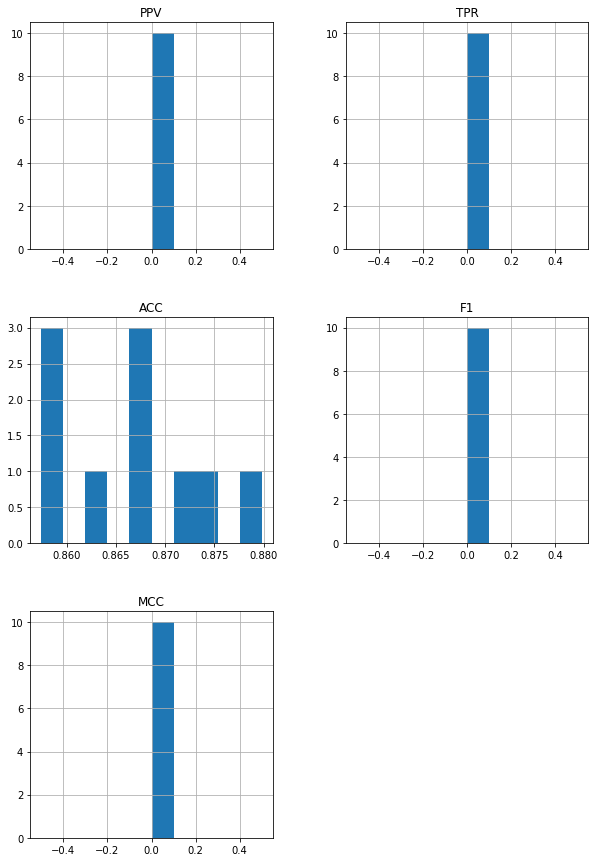

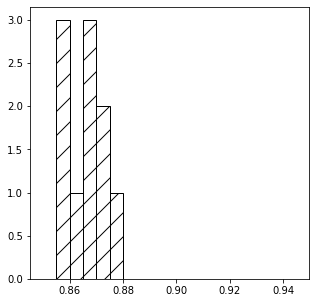

In [ ]:
%time
from sklearn import metrics 
def calculate_metric(X,Y, nIter):
    model = MultinomialNB()
    result = np.array([])
    #Pętla po kolejnych iteracjach procesu trenowania-testowania
    for i in range(nIter):
        #Podział próbki na części treningową i testową
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

        #Przeprowadzenie minmalizacji lub dopasowania parametrów modelu (ang. fit)
        model.fit(X_train,Y_train)

        #Predykcja
        y_pred = model.predict(X_test)  
        y_true = Y_test
        #Obliczenie wartości miar jakości
        PPV = metrics.precision_score(y_true, y_pred)
        TPR = metrics.recall_score(y_true, y_pred)
        ACC = metrics.accuracy_score(y_true, y_pred)
        F1 = metrics.f1_score(y_true, y_pred)
        MCC = metrics.matthews_corrcoef(y_true, y_pred)
        #Spakowanie uzyskanych licz do jednej macierzy
        result = np.append(result, np.array([PPV, TPR, ACC, F1, MCC]), axis=0)
        
    result = np.reshape(result, (-1,5))  
    result = pd.DataFrame(result, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])  
    return result     


#Obliczenie wartości metryk na pełnych danych    
metrics_data = calculate_metric(text_transformed, df["target"], nIter=10)
#Przepakowanie uzyskanych liczb do obiektu DataFrame
df_metrics = pd.DataFrame(data=metrics_data, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])
#Wyrysowanie histogramów dla wszystkich metryk
df_metrics.hist(figsize=(10,15))

#Obliczenie wartości metryk na 10% danych  
#df_sample= data.sample(frac = 0.1)
#df_metrics_10percent = calculate_metric(data_sample, nIter=100)


#Wyrysowanie rozkładu dokładności (ACC) dla obu zestawów danych 
axis = plt.figure(figsize=(5,5)).subplots(1, 1)
#df_metrics_10percent["ACC"].hist(ax = axis, bins=np.arange(0.85, 0.95, 0.005), grid=False)
df_metrics["ACC"].hist(ax=axis, bins=np.arange(0.85, 0.95, 0.005), fill=False, hatch="/", grid=False)

## Analiza modelu

Sprawdźmy, czego właściwie maszyna się nauczyła. Analizując współczynniki modelu proszę wskazać słowa które są istotne dkla klasyfikacji.

Proszę:
* wypisać na ekran współczynniki przypisane do kolejnych słów: ```MultinomialNB.coef_[0]```
* stworzyć listę zawierającą indeksy posortowanych współczynników: ```np.argsort(...)```
* wypisać na ekran po 10 słów o największych i najmniejszych wartościach współczynników.

**Wskazówka** by listę słów moć adresować listą indeksów, listę słów trzeba zamienić na macierz numpy.

In [ ]:
#np.argsort zwraca indeksy w oryginalnej tablicy, które odpowiadają posortowanej tablicy, np.:
#np.argsort([3,1,2]) ---> [1,2,0]
#.coef_[0] zwraca nam tablicę współczynników -- po jednym dla każdej cechy. 
# Wkład do decyzji klasyfikatora jest proporcjonalny do wartości tych współczynników -- większy współczynnik = ważniejsza cecha
feature_names = vectorizer.get_feature_names()
feature_names = np.array(feature_names)
coeff = model.coef_[0]
top10 = np.argsort(coeff)[-10:]
bottom10 = np.argsort(coeff)[:10]

print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:")
print(feature_names[top10])

print("Słowa najmniej istotne przy klasyfikacji:")
print(feature_names[bottom10])

Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:
['ala' 'kot' 'kota' 'ma' 'wszy']
Słowa najmniej istotne przy klasyfikacji:
['ala' 'kot' 'kota' 'ma' 'wszy']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


## Działanie modelu na nieznanych słowach.

Model jedynie rozpoznaje poszczególne słowa, be żadnej analizy językowej. Dodamy pewien element analizy językowej.
Proszę:

* wybrać dowolne, bezsensowne słowo które nie występuje w słowniku i sprawdzić, że tak jest
* dokończyć zdanie : ``Life is`` tym słowem
* wypisać postać ptrzetransformowaną, oraz jej transformację odwrotną
* sprawdzić jak na nie zareaguje model

In [ ]:
word = "loihg"
index = np.where(feature_names == word) 
print("Indeks słowa {} to: {}".format(word, index))

message = ["life is "+ word]
message_transformed = vectorizer.transform(message) 

print("Original text:" , message)
print("Message transformed: ", message_transformed)
print(vectorizer.inverse_transform(message_transformed))
           
result = model.predict(message_transformed)
print("Model result for senstence: \n {} is {}".format(message,result))

Indeks słowa loihg to: (array([], dtype=int64),)
Original text: ['life is loihg']
Message transformed:  
[array([], dtype='<U4')]
Model result for senstence: 
 ['life is loihg'] is ['ham']


### Stemming (nawet nie będę próbować tego tłumaczyć na polski, to [bogate](https://pl.bab.la/slownik/angielski-polski/stemming) znaczeniowo słowo)

Polega na ujednoliceniu słów o tym samym rdzeniu znaczeniowym (o czym maszyna, oczywiście, nie ma szans wiedzieć). Np. dzięki stemmingowi słowa "go", "going" i "goes" są przyporządkowane tylko jednemu słowu "go". Można np. użyć gotowego algorytmu stemmingowego o nazwie [Porter Stemmer](https://tartarus.org/martin/PorterStemmer/).

Proszę:

* wypisać na ekran indeksy słów ``going`` oraz ``go``

In [ ]:
id1 = np.where(feature_names == 'going')
id2 = np.where(feature_names == 'go')
print("Indices for words going and go are: ", id1, id2)

Indices for words going and go are:  (array([], dtype=int64),) (array([], dtype=int64),)


In [ ]:
!pip3 install nltk
import nltk
import ssl
# chcemy pobrac wytrenowany dla języka angielskeigo tokenizer Punkt
# poniższe linijki mają pomóc w przypadku problemów z ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
# pobieramy tokenizer
nltk.download('punkt')
# ładujemy przydatne funkcje
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# przykładowy tekst
message = 'Applying classical methods of machine learning to the study of quantum systems (sometimes called quantum machine learning) is the focus of an emergent area of physics research'
# tokenizujemy czyli dzielimy tekst na słowa
words = word_tokenize(message)

print("Message:\n",message)
print("tokens:\n",words)

# stwórz obiekt typu PorterStemmer
stemmer = PorterStemmer()
# użyj nowo stworzonego obiektu, żeby 'dostać temat' każdego ze słów
words = [stemmer.stem(word) for word in words]
print("words stems:\n",words)

Message:
 Applying classical methods of machine learning to the study of quantum systems (sometimes called quantum machine learning) is the focus of an emergent area of physics research
tokens:
 ['Applying', 'classical', 'methods', 'of', 'machine', 'learning', 'to', 'the', 'study', 'of', 'quantum', 'systems', '(', 'sometimes', 'called', 'quantum', 'machine', 'learning', ')', 'is', 'the', 'focus', 'of', 'an', 'emergent', 'area', 'of', 'physics', 'research']
words stems:
 ['appli', 'classic', 'method', 'of', 'machin', 'learn', 'to', 'the', 'studi', 'of', 'quantum', 'system', '(', 'sometim', 'call', 'quantum', 'machin', 'learn', ')', 'is', 'the', 'focu', 'of', 'an', 'emerg', 'area', 'of', 'physic', 'research']


Użycie klasy ```PorterStemmer()``` jako etapu pośdrednie między surowym tekstem, and ```CountVectorizer``` wymaga zdefiniowania obiektu ```analyzer```:

In [ ]:
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer=stemmed_words)

Powtórzmy trening i testowanie naszego klasyfikatora na danych poddanych stemmingowi. Proszę:

* stworzyć zmienną zawierająca kolumnę treścni maili
* poddać ją traqnsformacji za użyciem klasy ```PorterStemmer```
* podzielić dane na części uczącą i testową
* następnie wytrenować i poddać transformacji za pomocą ```CountVectorizer```
* następnie wytrenować model i wypisać dla niego wartości metryk

**Wskazówka** do transformacji kolumny słów użyć linii, które definiowała zmienną ```words``` w komórce powyżej.

### Wracamy do pracy nad zbiorem mejli

In [ ]:
# stwórz instancje obiektu CountVectorizer
vectorizer = vectorizer = CountVectorizer()
vectorizer.fit(text)

#przeprowadź serię transformacji
text = df["text"]
text_stemmed = [stemmer.stem(word) for word in text]
text_transformed = vectorizer.transform(text_stemmed)

#przeprowadź podział na dane uczące i treningowe
X_train, X_test, Y_train, Y_test = X_train, X_test, Y_train, Y_test = train_test_split(text_transformed,df["label"], test_size = 0.3)

# stwórz obiekt klasyfikatora
model = MultinomialNB()

# naucz klasyfikator na zbiorze uczącym
model.fit(X_train, Y_train)

# wypisz wartości metryk
printScores(model,X_test, Y_test)

Classification report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1447
        spam       0.91      0.93      0.92       225

    accuracy                           0.98      1672
   macro avg       0.95      0.96      0.95      1672
weighted avg       0.98      0.98      0.98      1672

Confusion matrix:
[[1427   20]
 [  16  209]]


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


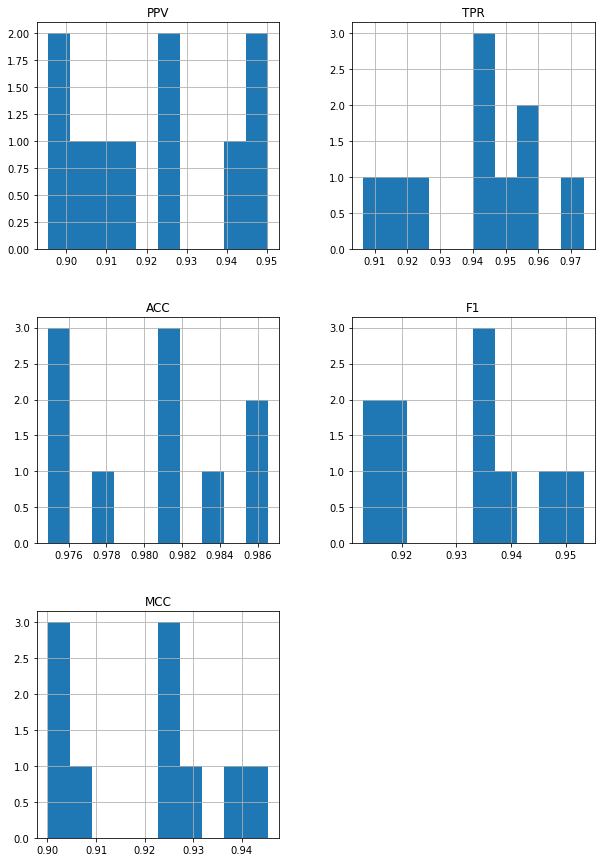

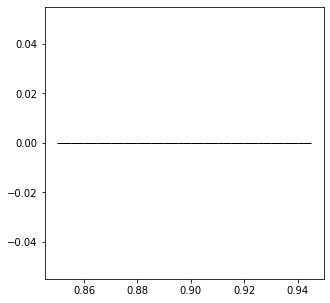

In [ ]:
%time
from sklearn import metrics 
def calculate_metric(X,Y, nIter):
    model = MultinomialNB()
    result = np.array([])
    #Pętla po kolejnych iteracjach procesu trenowania-testowania
    for i in range(nIter):
        #Podział próbki na części treningową i testową
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

        #Przeprowadzenie minmalizacji lub dopasowania parametrów modelu (ang. fit)
        model.fit(X_train,Y_train)

        #Predykcja
        y_pred = model.predict(X_test)  
        y_true = Y_test
        #Obliczenie wartości miar jakości
        PPV = metrics.precision_score(y_true, y_pred)
        TPR = metrics.recall_score(y_true, y_pred)
        ACC = metrics.accuracy_score(y_true, y_pred)
        F1 = metrics.f1_score(y_true, y_pred)
        MCC = metrics.matthews_corrcoef(y_true, y_pred)
        #Spakowanie uzyskanych licz do jednej macierzy
        result = np.append(result, np.array([PPV, TPR, ACC, F1, MCC]), axis=0)
        
    result = np.reshape(result, (-1,5))  
    result = pd.DataFrame(result, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])  
    return result     


#Obliczenie wartości metryk na pełnych danych    
metrics_data = calculate_metric(text_transformed, df["target"], nIter=10)
#Przepakowanie uzyskanych liczb do obiektu DataFrame
df_metrics = pd.DataFrame(data=metrics_data, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])
#Wyrysowanie histogramów dla wszystkich metryk
df_metrics.hist(figsize=(10,15))

#Obliczenie wartości metryk na 10% danych  
#df_sample= data.sample(frac = 0.1)
#df_metrics_10percent = calculate_metric(data_sample, nIter=100)


#Wyrysowanie rozkładu dokładności (ACC) dla obu zestawów danych 
axis = plt.figure(figsize=(5,5)).subplots(1, 1)
#df_metrics_10percent["ACC"].hist(ax = axis, bins=np.arange(0.85, 0.95, 0.005), grid=False)
df_metrics["ACC"].hist(ax=axis, bins=np.arange(0.85, 0.95, 0.005), fill=False, hatch="/", grid=False)

## Gdybyście byli spammerami... Co moglibyście zrobić, znając tę technikę antyspamową?

### Stosowanie znaków specjalnych zamiast liter

In [ ]:
our_message = vectorizer.transform(['call for free'])
print(model.predict(our_message))
# podmieniamy literkę a na małpę @
our_tricky_message = vectorizer.transform(['c@ll for free'])
print(model.predict(our_tricky_message))

['spam']
['ham']


Jakieś inne pomysły? :)

In [ ]:
our_tricky_message = vectorizer.transform(['Call for free sex otherwise you miss a very important meeting'])
print(model.predict(our_tricky_message))

['ham']


#### Dlaczego powyższa wiadomość została sklasyfikowana jako pożądana, chociaż jest ewidentnym przykładem spamu?